# Time series correlation
## Import libraries

In [1]:
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Read and process data

In [41]:
# read data
# TODO: loop through the different tabs in excel
coronavirus = pd.read_excel('./data/time_series.xlsx', sheet_name='coronavirus', header=[0], index_col=[0])
educacion = pd.read_excel('./data/time_series.xlsx', sheet_name='educacion', header=[0], index_col=[0])
musica = pd.read_excel('./data/time_series.xlsx', sheet_name='musica', header=[0], index_col=[0])
trabajo = pd.read_excel('./data/time_series.xlsx', sheet_name='trabajo', header=[0], index_col=[0])

# Transpose each tab and store on its own dataframe, name columns and assign topic value
coronavirus = coronavirus.transpose().reset_index()
coronavirus.columns = ['date','Factiva','GoogleTrends']
coronavirus['topic'] = 'coronavirus'
educacion = educacion.transpose().reset_index()
educacion.columns = ['date','Factiva','GoogleTrends']
educacion['topic'] = 'educacion'
musica = musica.transpose().reset_index()
musica.columns = ['date','Factiva','GoogleTrends']
musica['topic'] = 'musica'
trabajo = trabajo.transpose().reset_index()
trabajo.columns = ['date','Factiva','GoogleTrends']
trabajo['topic'] = 'trabajo'

# Put all processed dataframes together
data = pd.concat([coronavirus,educacion,musica,trabajo],axis=0)
data

,date,Factiva,GoogleTrends,topic
0,2020-01-01,0,0,coronavirus
1,2020-01-02,0,0,coronavirus
2,2020-01-03,0,0,coronavirus
3,2020-01-04,0,4,coronavirus
4,2020-01-05,0,0,coronavirus
...,...,...,...,...
177,2020-06-26,28,0,trabajo
178,2020-06-27,11,0,trabajo
179,2020-06-28,16,0,trabajo
180,2020-06-29,14,10,trabajo


In [42]:
# Convert the two source columns into a dimension "source"
data_melted = data.melt(id_vars=['date','topic'], var_name='source', value_vars=['Factiva','GoogleTrends'])
data_melted

,date,topic,source,value
0,2020-01-01,coronavirus,Factiva,0
1,2020-01-02,coronavirus,Factiva,0
2,2020-01-03,coronavirus,Factiva,0
3,2020-01-04,coronavirus,Factiva,0
4,2020-01-05,coronavirus,Factiva,0
...,...,...,...,...
1451,2020-06-26,trabajo,GoogleTrends,0
1452,2020-06-27,trabajo,GoogleTrends,0
1453,2020-06-28,trabajo,GoogleTrends,0
1454,2020-06-29,trabajo,GoogleTrends,10


In [103]:
# Set the topic
topic = 'musica'

In [104]:
# Graph the number of hits per source
# TODO: fix the warning that appear with new version of pandas
g = px.line(data_melted[data_melted.topic==topic], x='date', y='value', color='source')
g.show()

c:\Users\ivano\Desktop\DataStuff\envs\todoterreno\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [105]:
# Get pearson and spearment correlation for all data together using pandas built-in function
p_pearson = data[data.topic==topic][['Factiva','GoogleTrends']].corr(method='pearson')
print(p_pearson)
p_spearman = data[data.topic==topic][['Factiva','GoogleTrends']].corr(method='spearman')
print(p_spearman)


               Factiva  GoogleTrends
Factiva       1.000000      0.477908
GoogleTrends  0.477908      1.000000
               Factiva  GoogleTrends
Factiva       1.000000      0.603799
GoogleTrends  0.603799      1.000000


In [106]:
# Get pearson correlation using scipy, confirming pandas is doing the right thing
r, p = stats.pearsonr(data[data.topic==topic]['Factiva'],data[data.topic==topic]['GoogleTrends'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: 0.47790819673973833 and p-value: 8.95621304375868e-12


In [107]:
# Calculate the rolling median with a specified window length preferably according to seasonality, weekly intervals?
rolling_median = data[data.topic==topic][['Factiva','GoogleTrends']].rolling(window=7, center=True).median()
rolling_median

,Factiva,GoogleTrends
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,0.0,45.0
4,0.0,45.0
...,...,...
177,13.0,56.0
178,13.0,56.0
179,NaN,NaN
180,NaN,NaN


In [108]:
# Graph rolling median
# TODO: Add real dates on x-axis
g = px.line(rolling_median)
g.show()

In [109]:
data_interpol['Factiva'].rolling(window=rolling_window_size, center=True)

Rolling [window=7,center=True,axis=0,method=single]

In [110]:
# Calculate the correction by window segments using the median or real values
#TODO: 
# Add real index
# compute for all topics in a loop
# function to calculate it all
# investigate how seasonality affects it
# draw topics on separate axis?
# add granger test with lagged 

# Set the size for the window segments
rolling_window_size = 7

# Interpolate data so the time series has continuity, by default using linear interpolation (might not be such a good idea)
data_interpol = data[data.topic==topic][['Factiva','GoogleTrends']].interpolate()
data_interpo = data[data.topic==topic][['Factiva','GoogleTrends']]
data_interpol_median = rolling_median[['Factiva','GoogleTrends']].interpolate()
data_interpol_median = rolling_median[['Factiva','GoogleTrends']]

# Measure the correlation between the rolling window on one side and the other source, explore the two directions
data_rollingF = data_interpol['Factiva'].rolling(window=rolling_window_size, center=True).corr(data_interpol['GoogleTrends'])
data_rolling_medianF = data_interpol_median['Factiva'].rolling(window=rolling_window_size, center=True).corr(data_interpol['GoogleTrends'])

data_rollingG = data_interpol['GoogleTrends'].rolling(window=rolling_window_size, center=True).corr(data_interpol['Factiva'])
data_rolling_medianG = data_interpol_median['GoogleTrends'].rolling(window=rolling_window_size, center=True).corr(data_interpol['Factiva'])

data_rollingF

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
177   -0.378636
178   -0.392598
179         NaN
180         NaN
181         NaN
Length: 182, dtype: float64

In [111]:
# Graph correlation between rolling window Factiva and Google Trends
g = px.line(data_rollingF)
g.show()

In [114]:
# Check the correlation between median rolling window Factiva and Google Trends
g = px.line(data_rolling_medianF)
g.show()

In [115]:
# Create two new dataframes with each topic for analysing cross correlation
d1 = data[data.topic==topic]['Factiva'].fillna(0)
d2 = data[data.topic==topic]['GoogleTrends'].fillna(0)

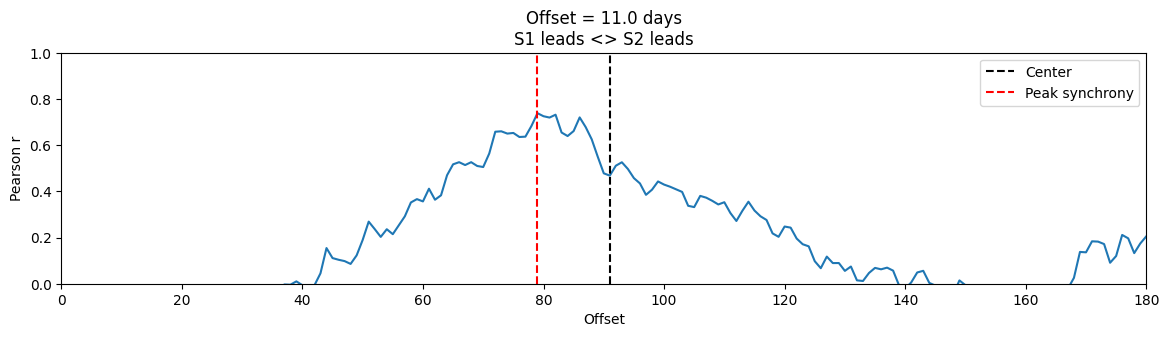

In [117]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

lag_window = 90

rs = [crosscorr(d1,d2, lag) for lag in range(-int(lag_window),int(lag_window+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} days\nS1 leads <> S2 leads',ylim=[0,1],xlim=[0,lag_window*2], xlabel='Offset',ylabel='Pearson r')
#ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
#ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend();

In [118]:
# Recreate per topic dataframes for window time lagged cross correlation
d1 = data[data.topic==topic]['Factiva'].fillna(0)
d2 = data[data.topic==topic]['GoogleTrends'].fillna(0)

In [121]:
# Windowed time lagged cross correlation
lag_window = 14
no_splits = 10
samples_per_split = 18
rss=[]
for t in range(0, no_splits):
    d1w = d1.loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2w = d2.loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1w,d2w, lag) for lag in range(-int(lag_window),int(lag_window+1))]
    rss.append(rs)
rss_wtl = pd.DataFrame(rss).fillna(0)

rss_wtl

c:\Users\ivano\Desktop\DataStuff\envs\todoterreno\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

c:\Users\ivano\Desktop\DataStuff\envs\todoterreno\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-0.235793,-2.476539e-01,-0.329321,...,0.007896,0.047957,-0.336452,-0.431774,0.452021,0.225018,0.315691,-0.396177,-0.500000,-0.430331
2,-0.484281,0.032880,0.916827,0.051568,-2.241379e-01,-0.327178,-0.030295,0.556413,7.314786e-18,-0.052194,...,-0.151299,0.110817,0.552889,-0.181334,-0.382780,0.022283,0.190278,0.555696,-0.247645,-0.367484
3,-0.944444,-0.138675,-0.339450,-0.859976,-8.212465e-01,-0.616495,-0.419990,-0.078160,-1.001457e-01,-0.157701,...,0.341647,0.012058,-0.349969,-0.400389,-0.301765,0.273738,0.583701,0.529004,0.603591,0.348098
4,-0.364347,-0.194949,-0.062461,0.634702,1.726833e-17,0.080333,-0.274492,-0.007549,-1.521267e-01,0.153864,...,-0.418728,0.010840,-0.047192,-0.173610,-0.420312,-0.555923,-0.460114,-0.136178,0.496550,-0.357261
5,-0.753608,-0.620393,0.096139,0.797933,8.394801e-01,0.290210,0.049310,-0.366780,-5.097643e-01,-0.031455,...,0.262242,-0.209589,-0.568763,-0.160703,0.654987,0.409229,-0.417713,-0.428423,0.242028,0.238413
6,-0.942477,-0.436559,0.067743,0.534427,4.281366e-01,0.059906,0.302334,-0.320532,1.995395e-01,-0.010832,...,-0.032000,0.534898,-0.069332,-0.220285,0.299347,-0.072655,-0.480170,0.421897,0.747179,0.254510
7,-0.290013,0.307827,0.749551,0.179847,-2.751024e-01,0.000000,0.123584,-0.016246,8.690128e-02,0.209293,...,-0.274006,0.168679,0.160351,0.365874,-0.318473,0.207027,-0.128581,-0.037318,0.524107,-0.674453
8,-0.813209,-0.038283,0.263813,-0.404857,-3.475268e-01,0.219463,0.652523,0.176760,6.492832e-02,0.125797,...,0.143359,0.063927,0.147078,-0.455716,-0.475678,-0.179863,0.421779,0.296732,0.287333,-0.519809
9,0.343494,-0.779354,-0.715710,0.095481,6.595371e-01,0.402356,0.040366,-0.222755,-6.091310e-01,-0.138994,...,-0.014781,-0.138320,-0.720518,0.110029,0.366724,-0.054846,-0.168178,0.010159,-0.038589,-0.450817


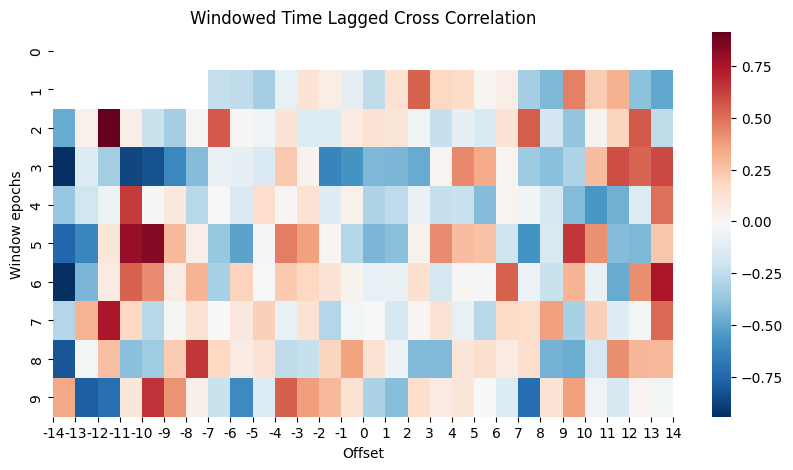

In [122]:
# Graph the window lagged cross correlation
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,lag_window+1], xlabel='Offset',ylabel='Window epochs');
ax.set_xticks(range(0,int(lag_window*2+1)));
ax.set_xticklabels(range(-int(lag_window),int(lag_window+1)));

In [123]:
# Recreate per topic dataframes for window time lagged cross correlation
d1 = data[data.topic==topic]['Factiva'].fillna(0)
d2 = data[data.topic==topic]['GoogleTrends'].fillna(0)

In [124]:
# Rolling window time lagged cross correlation
lag_window = 7
window_size = 14 #samples
t_start = 0
t_end = t_start + window_size
step_size = 1
rss=[]
while t_end < 180:
    d1wt = data[data.topic==topic]['Factiva'].iloc[t_start:t_end]
    d2wt = data[data.topic==topic]['GoogleTrends'].iloc[t_start:t_end]
    rs = [crosscorr(d1wt,d2wt, lag, wrap=False) for lag in range(-int(lag_window),int(lag_window+1))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss_rwtl = pd.DataFrame(rss)

rss_rwtl

c:\Users\ivano\Desktop\DataStuff\envs\todoterreno\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

c:\Users\ivano\Desktop\DataStuff\envs\todoterreno\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0.034215,-0.753112,-0.584022,0.483285,0.588234,0.349056,0.021934,-0.290683,-0.626258,-0.026652,0.661107,0.610091,0.174437,-0.348151,-0.517963
162,-0.320263,-0.772785,-0.420419,0.626488,0.746597,0.446625,-0.140050,-0.138742,-0.491419,0.126135,0.426311,0.441557,0.288659,-0.278429,-0.531031
163,-0.366579,-0.691772,-0.252468,0.649619,0.747821,0.237827,-0.051488,-0.157298,-0.514355,0.072955,0.253846,0.430567,0.366087,-0.226570,-0.488867
164,-0.341314,-0.564960,-0.209248,0.642367,0.619595,0.252225,-0.131770,-0.182251,-0.539691,-0.030684,0.147645,0.266354,0.637361,-0.028231,-0.565854


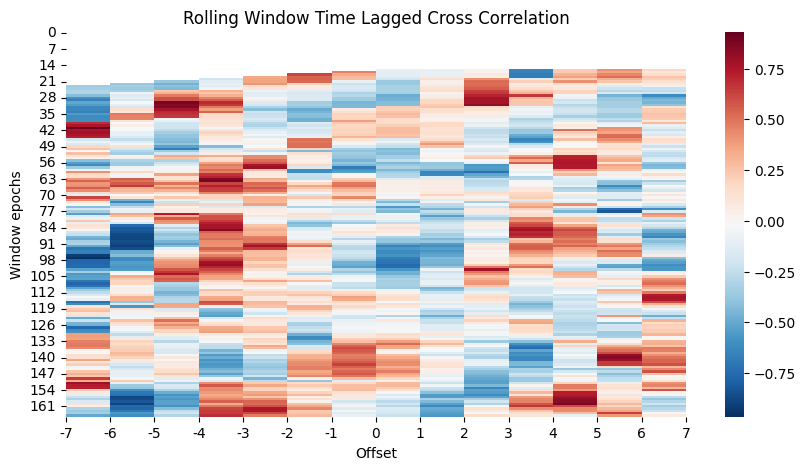

In [126]:
# Graph the window lagged cross correlation
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss_rwtl,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Window Time Lagged Cross Correlation',xlim=[0,lag_window+1], xlabel='Offset',ylabel='Window epochs');
ax.set_xticks(range(0,int(lag_window*2+1)));
ax.set_xticklabels(range(-int(lag_window),int(lag_window+1)));